In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd


from nonlocalunet.models import NonLocalUnet
from liverfiles.metrics import dr_score, mhd_score
from liverfiles.Trainer import Trainer
from liverfiles.utils import *
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from liverfiles.loader import Ds

import random

import multiprocessing
from joblib import Parallel, delayed
from tqdm import trange
from tqdm.notebook import tqdm

# Data

In [2]:
def preprocess(img, mask, size):
    depth_idx = list(range(0, img.shape[-1], img.shape[-1]//size[-1]))[:size[-1]]
    img = img[:,:,depth_idx]
    img = min_max(img)
    img = cv2.resize(img, (size[0],size[1]))
    mask = mask[:,:,depth_idx]
    mask = cv2.resize(mask, (size[0],size[1]))
    return img, mask

In [3]:
pathes = []
for (dirpath, dirnames, filenames) in os.walk('data'):
    if dirpath == os.path.join('data', 'segmentations'):
        continue
    pathes.extend([os.path.join(dirpath, i)for i in filenames] )
df = pd.DataFrame({'path': pathes})
df['id'] = df.path.str.split(os.path.sep).str[-1].str[7:-4]
df.id = df.id.astype('int16')
df = df.sort_values(by='id').reset_index(drop=True)

In [4]:
# imgs, masks = [], []
# size = (224,224, 64)
# for path, mask_id in tqdm(df.values):
#     img, mask = preprocess(get_nii(path), get_mask(mask_id), size)
#     imgs.append(img)
#     masks.append(mask)
# np.save('processed data/imgs', np.array(imgs))
# np.save('processed data/masks', np.array(masks).astype('uint8'))

In [5]:
imgs = np.load('processed data/imgs.npy')
masks = np.load('processed data/masks.npy')

imgs = np.transpose(imgs, (0, 3, 2, 1))
masks = np.transpose(masks, (0, 3, 2, 1))

# Dataloader

In [6]:
shape = (32, 32, 32)

val_size = 2
train_ds = Ds(imgs[:-val_size], masks[:-val_size], shape, None, nonzero_prob=1)

train_dl = DataLoader(train_ds,
                      batch_size=3,
                      shuffle=True,
                      num_workers=8,
                      pin_memory=False,
                      drop_last=False)


val_df = (imgs[-val_size:], masks[-val_size:])
# val_ds = Ds(df[-val_size:], shape, None)
# val_dl = DataLoader(val_ds,
#                      batch_size=3,
#                      shuffle=False,
#                      num_workers=8,
#                      pin_memory=False,
#                      drop_last=False)
#test1, test2 = next(iter(train_dl))

# Visualization

In [7]:
a, b = next(iter(train_dl))
c = 0

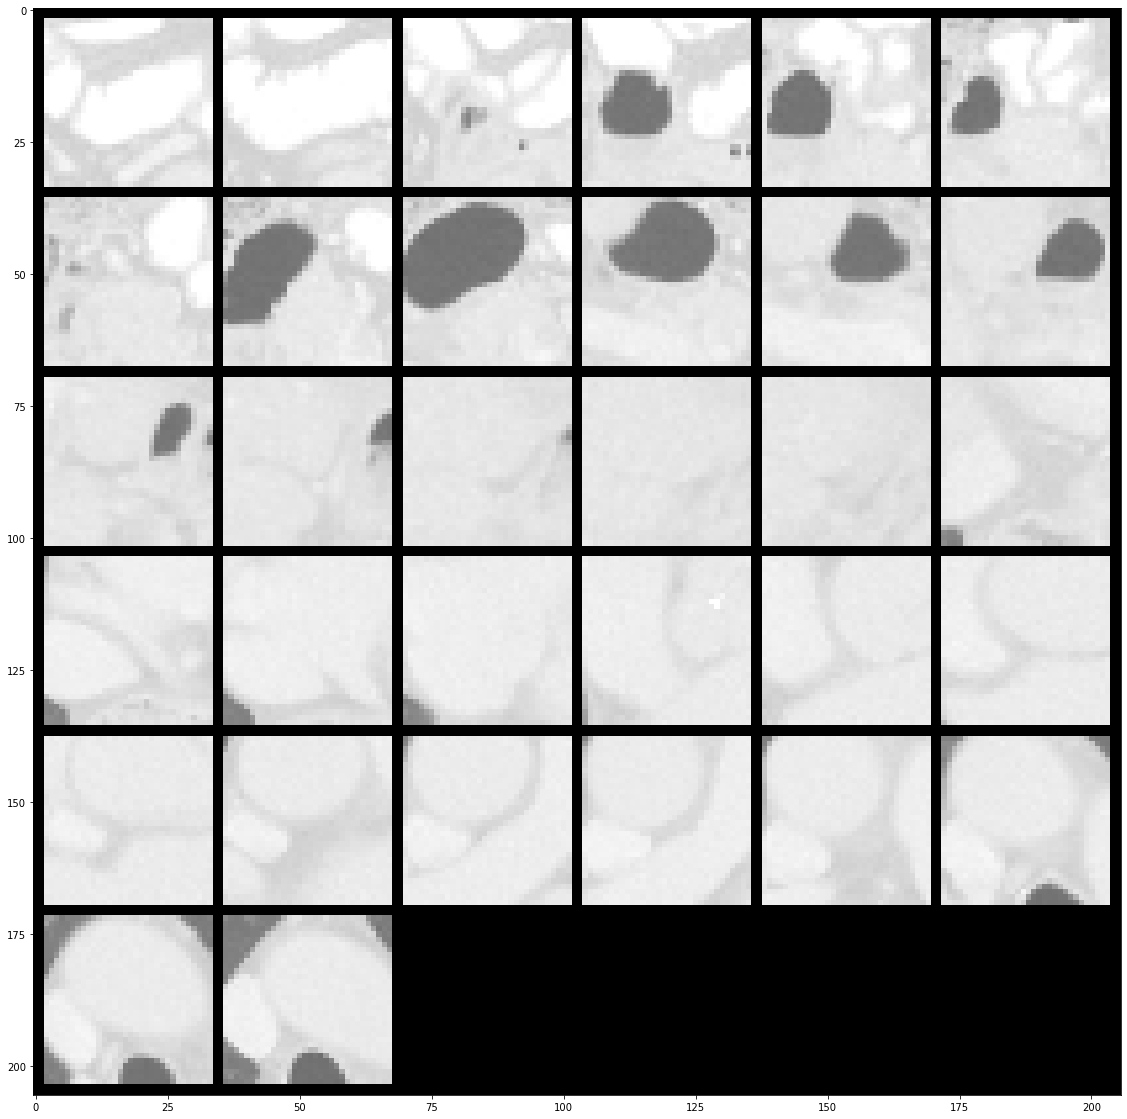

In [8]:
example = torchvision.utils.make_grid(torch.transpose(a[c], 0,1), nrow=6)
plt.figure(figsize=(20,20))
plt.imshow(example.permute(1,2,0))

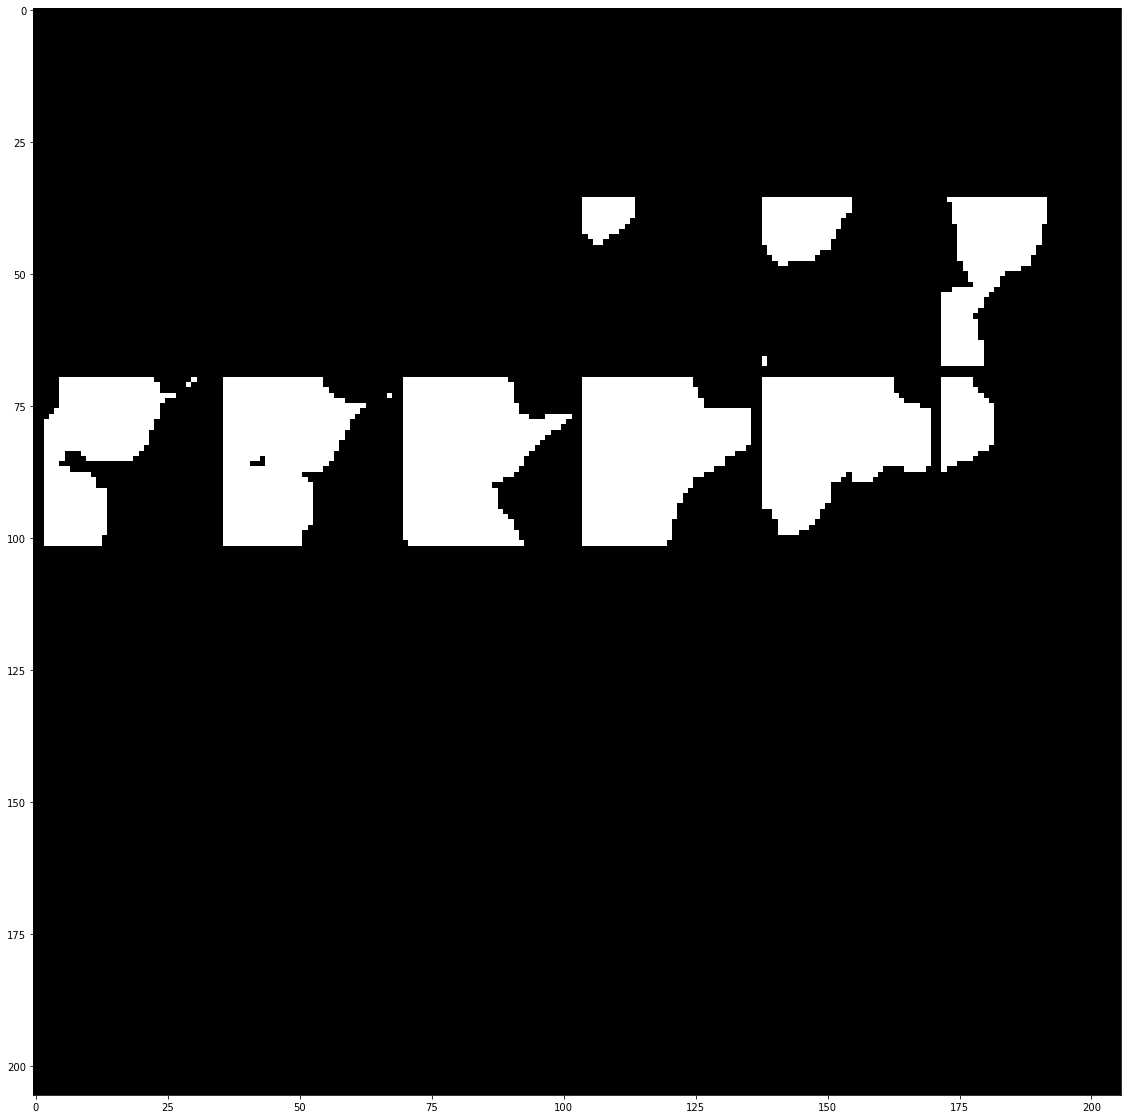

In [9]:
example = torchvision.utils.make_grid(torch.transpose(b[c], 0,1)[:,0:1,:,:].float(), nrow=6)
plt.figure(figsize=(20,20))
plt.imshow(example.permute(1,2,0))
c+=1

# Model

In [7]:
model = NonLocalUnet(1, 2).to('cuda')
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.BCELoss()
device = 'cuda'

In [8]:
count_parameters(model)

+---------------------------------------------+------------+
|                   Modules                   | Parameters |
+---------------------------------------------+------------+
|        input_block.batch_norm1.weight       |     1      |
|         input_block.batch_norm1.bias        |     1      |
|        input_block.batch_norm2.weight       |     1      |
|         input_block.batch_norm2.bias        |     1      |
|           input_block.conv1.weight          |     27     |
|            input_block.conv1.bias           |     1      |
|           input_block.conv2.weight          |     27     |
|            input_block.conv2.bias           |     1      |
|              conv_input.weight              |     32     |
|               conv_input.bias               |     32     |
|       down_sample1.batch_norm1.weight       |     32     |
|        down_sample1.batch_norm1.bias        |     32     |
|       down_sample1.batch_norm2.weight       |     64     |
|        down_sample1.ba

1152478

In [9]:
trainer = Trainer(model, optimizer, scheduler, criterion, train_dl, val_df, device, 'first run')

In [ ]:
trainer.train(2000)

/home/aykhan123/Desktop/job/Non-local-U-Net-Pytorch/liverfiles/metrics.py:27: UserWarning: `x` isn't a recognized object; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result_by_channel += max(directed_hausdorff(a, b)[0], directed_hausdorff(b, a)[0])
